# Transfer learning with Inception v3
Rupert Thomas - Nov 2017

This demo covers retraining a pre-trained Inception v3 network in Keras/TensorFlow. Originally trained using the ImageNet dataset, we use the Kaggle Cats and Dogs dataset to adapt the network for a new purpose.

Based on code from: https://deeplearningsandbox.com/how-to-use-transfer-learning-and-fine-tuning-in-keras-and-tensorflow-to-build-an-image-recognition-94b0b02444f2

In [11]:
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import datetime
import urllib
import zipfile
import glob
import shutil
#from sklearn.model_selection import train_test_split
from random import shuffle

from keras import __version__
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
IM_WIDTH, IM_HEIGHT = 299, 299  # fixed size for InceptionV3
NUM_COLOUR_CHANNELS = 3  # must be 3 for pre-trained weights
NB_EPOCHS = 3
BATCH_SIZE = 32
FC_SIZE = 1024
NB_IV3_LAYERS_TO_FREEZE = 172  # layers to freeze during fine-tuning

MULTILABEL = False  # if multilabel, classes are not mutually exclusive

output_model_file_suffix = 'inception_V3_retrained.h5'

MODEL_PATH = 'output'

if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

In [3]:
# Download dataset
# N.B. these are sitting in my Dropbox, so may disappear at some point/be a little slow. 
# You can manually download the training file here, with a Kaggle account:
# https://www.kaggle.com/c/dogs-vs-cats/data

if not os.path.exists('data'):
    os.mkdir('data')

if not os.path.exists('data/train.zip'):
    urllib.request.urlretrieve("https://www.dropbox.com/s/qhghnv5l1eoxkxc/train.zip?raw=1", "data/train.zip")

    with zipfile.ZipFile('data/train.zip', "r") as z:
        z.extractall('data/')


In [4]:
# Split up the dataset, and move images into class-specific subdirectories (Keras likes this setup)

train_path = 'data/train'
if not os.path.exists(train_path):
    os.mkdir(train_path)
if not os.path.exists(os.path.join(train_path, 'cat')):
    os.mkdir(os.path.join(train_path, 'cat'))
if not os.path.exists(os.path.join(train_path, 'dog')):
    os.mkdir(os.path.join(train_path, 'dog'))
    
test_path = 'data/test'
if not os.path.exists(test_path):
    os.mkdir(test_path)
if not os.path.exists(os.path.join(test_path, 'cat')):
    os.mkdir(os.path.join(test_path, 'cat'))
if not os.path.exists(os.path.join(test_path, 'dog')):
    os.mkdir(os.path.join(test_path, 'dog'))

train_files = glob.glob(os.path.join(train_path, '*.jpg'))

# Split into training and test subsets
#train_files, test_files = train_test_split(train_files, test_size=0.1)
shuffle(train_files)
cut_off = len(train_files) // 10
train_files, test_files = train_files[cut_off:], train_files[:cut_off]

# Move training files into their class subdirectories
for file_path in train_files:
    if 'cat' in file_path:
        shutil.move(file_path, os.path.join(train_path, 'cat', os.path.basename(file_path)))
    if 'dog' in file_path:
        shutil.move(file_path, os.path.join(train_path, 'dog', os.path.basename(file_path)))

# Move test files
for file_path in test_files:
    if 'cat' in file_path:
        shutil.move(file_path, os.path.join(test_path, 'cat', os.path.basename(file_path)))
    if 'dog' in file_path:
        shutil.move(file_path, os.path.join(test_path, 'dog', os.path.basename(file_path)))


In [5]:
# Some support functions

def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
            cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt


def plot_training(history):
    fig,ax_arr = plt.subplots(nrows=2, figsize=(10,10))
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    ax_arr[0].plot(epochs, acc, 'r.')
    ax_arr[0].plot(epochs, val_acc, 'r')
    ax_arr[0].set_title('Training and validation accuracy')
    ax_arr[0].yaxis.set_major_formatter(FuncFormatter('{0:.1%}'.format))
    
    ax_arr[1].plot(epochs, loss, 'r.')
    ax_arr[1].plot(epochs, val_loss, 'r-')
    ax_arr[1].set_title('Training and validation loss')
    ax_arr[1].set_xlabel('Epochs')
    
    for ax in ax_arr:
        
        for item in [ax.title, ax.xaxis.label, ax.yaxis.label]:
            item.set_fontsize(16)
        for item in ([] + ax.get_xticklabels() + ax.get_yticklabels()):          
            item.set_fontsize(14)
    
    plt.legend(labels=['Training', 'Validation'])
    plt.show()
    
    return fig

In [6]:
# Setup an input pipeline, to feed training data in

nb_train_samples = get_nb_files(train_path)
nb_classes = len(glob.glob(train_path + "/*"))
nb_test_samples = get_nb_files(test_path)

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(train_path, target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True)

test_generator = test_datagen.flow_from_directory(test_path, target_size=(IM_WIDTH, IM_HEIGHT),
    batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Build the network

In [7]:
# Create base model
#base_model = InceptionV3(input_shape=(IM_WIDTH, IM_HEIGHT, NUM_COLOUR_CHANNELS), weights=None, include_top=False)  # do not use pre-trained weights (e.g. if different input shape)
base_model = InceptionV3(input_shape=(IM_WIDTH, IM_HEIGHT, NUM_COLOUR_CHANNELS), weights='imagenet', include_top=False)  # include_top=False excludes final FC layer #weights='imagenet',

# Top Model Block
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
x = Dense(FC_SIZE, activation='relu')(x)  # new FC layer, random init
if MULTILABEL:
    predictions = Dense(nb_classes, activation='sigmoid')(x)  # new sigmoid layer, so that each class probability is independent
else:
    predictions = Dense(nb_classes, activation='softmax')(x)  # new softmax layer: class probabilities sum to 1

# add your top layer block to your base model
model = Model(base_model.input, predictions)

loss_func = 'categorical_crossentropy'

## Training

### Transfer learning

In [8]:
# Transfer Learning: train only the top layers (which were randomly initialized)
# i.e. freeze all layers of the based model that is already pre-trained.
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='nadam', loss=loss_func, metrics=['accuracy'])
    
NB_EPOCHS = 3
workers_per_gpu = 6
model_desc = 'cats_and_dogs'
desc = 'TL_%s_epochs_%s'%(NB_EPOCHS,model_desc)
timestamp = datetime.datetime.today().strftime('%Y%m%d%H%M%S')

# Create call-backs: save checkpoint each epoch if better, and stop early if not improving
# N.B. ModelCheckpoint not currently working with multi-gpu
#top_weights_path = os.path.join(MODEL_PATH, timestamp+'_'+desc+'_top_model_weights.h5')
callbacks_list = [
    #ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=5, verbose=0)
]

history = model.fit_generator(train_generator, epochs=NB_EPOCHS, steps_per_epoch=nb_train_samples // BATCH_SIZE,
                          validation_data=test_generator, validation_steps=nb_test_samples // BATCH_SIZE,
                          class_weight='auto', verbose=1, workers=workers_per_gpu, callbacks=callbacks_list)

#save_model_path = os.path.join(MODEL_PATH, timestamp+'_'+desc+'_'+output_model_file_suffix)
#model.load_weights(top_weights_path) # load the best weights from the training
#model.save(save_model_path)

Epoch 1/1
703/703 [==============================] - 125s 177ms/step - loss: 0.1931 - acc: 0.9320 - val_loss: 0.0561 - val_acc: 0.9796


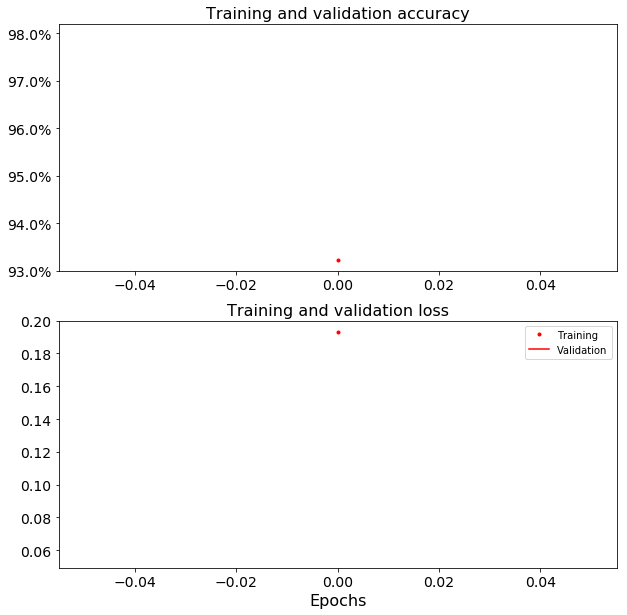

In [9]:
# Plot training history
fig = plot_training(history)
#fig.savefig(os.path.join(MODEL_PATH, timestamp+'_'+desc+'_'+'training_history.jpg'))

### Fine tuning

In [ ]:
# Train the classifier and the top two Inception blocks, but not the whole stack
for layer in model.layers[:NB_IV3_LAYERS_TO_FREEZE]:
    layer.trainable = False
for layer in model.layers[NB_IV3_LAYERS_TO_FREEZE:]:
    layer.trainable = True
    
model.compile(optimizer='nadam', loss=loss_func, metrics=['accuracy'])
    
NB_EPOCHS = 3
workers_per_gpu = 6
desc = desc+'_then_fine_tune'
timestamp = datetime.datetime.today().strftime('%Y%m%d%H%M%S')

# Create call-backs: save checkpoint each epoch if better, and stop early if not improving
# N.B. ModelCheckpoint not currently working with multi-gpu
#top_weights_path = os.path.join(MODEL_PATH, timestamp+'_'+desc+'_top_model_weights.h5')
callbacks_list = [
    ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    #EarlyStopping(monitor='val_acc', patience=5, verbose=0)
]

history = model.fit_generator(train_generator, epochs=NB_EPOCHS, steps_per_epoch=nb_train_samples // BATCH_SIZE,
                          validation_data=test_generator, validation_steps=nb_test_samples // BATCH_SIZE,
                          class_weight='auto', verbose=1, workers=workers_per_gpu, callbacks=callbacks_list)

save_model_path = os.path.join(MODEL_PATH, timestamp+'_'+desc+'_'+output_model_file_suffix)
#model.load_weights(top_weights_path) # load the best weights from the training
#model.save(save_model_path)

In [ ]:
# Plot training history
fig = plot_training(history)
#fig.savefig(os.path.join(MODEL_PATH, timestamp+'_'+desc+'_'+'training_history.jpg'))

### Full training

I've included full training here for completeness, but with this size dataset it will probably over-fit very quickly. Look out for divergence between the accuracy on the training set and the test set.

In [ ]:
# Train all layers
for layer in model.layers:
    layer.trainable = True
    
model.compile(optimizer='nadam', loss=loss_func, metrics=['accuracy'])
    
NB_EPOCHS = 3
workers_per_gpu = 6

# # if starting from scratch
# model_desc = 'cats_and_dogs'
# desc = 'full_train_%s_epochs_%s'%(NB_EPOCHS,model_desc)

# if previously done TL or FT 
desc = desc+'_full_train'
timestamp = datetime.datetime.today().strftime('%Y%m%d%H%M%S')

# Create call-backs: save checkpoint each epoch if better, and stop early if not improving
# N.B. ModelCheckpoint not currently working with multi-gpu
#top_weights_path = os.path.join(MODEL_PATH, timestamp+'_'+desc+'_top_model_weights.h5')
callbacks_list = [
    ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    #EarlyStopping(monitor='val_acc', patience=5, verbose=0)
]

history = model.fit_generator(train_generator, epochs=NB_EPOCHS, steps_per_epoch=nb_train_samples // BATCH_SIZE,
                          validation_data=test_generator, validation_steps=nb_test_samples // BATCH_SIZE,
                          class_weight='auto', verbose=1, workers=workers_per_gpu, callbacks=callbacks_list)

#save_model_path = os.path.join(MODEL_PATH, timestamp+'_'+desc+'_'+output_model_file_suffix)
#model.load_weights(top_weights_path) # load the best weights from the training
#model.save(save_model_path)

In [ ]:
# Plot training history
fig = plot_training(history)
#fig.savefig(os.path.join(MODEL_PATH, timestamp+'_'+desc+'_'+'training_history.jpg'))
#plt.close('all')

## Evaluate performance

In [13]:
# Evaluate on test data
test_generator.reset()
y_test = test_generator.classes  # get true values for the test dataset. Do not shuffle the test dataset!
y_hat = model.predict_generator(test_generator, workers=6)
pred = np.argmax(y_hat, axis=1)

print('Test accuracy: %0.3f' % (np.sum(pred == y_test) / len(pred)))

Test accuracy: 0.980


In [21]:
# Support functions for plotting a confusion matrix

# Normally I would just import the confusion_matrix code straight from scikit-learn,
# but I've copied it here, and jerry-rigged it to work without the library,
# as it appears to not be installed on the AWS build.

from scipy.sparse import coo_matrix
#from sklearn.metrics import confusion_matrix
import itertools

def confusion_matrix(y_true, y_pred, labels=None, sample_weight=None):
    """Compute confusion matrix to evaluate the accuracy of a classification
    By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
    is equal to the number of observations known to be in group :math:`i` but
    predicted to be in group :math:`j`.
    Thus in binary classification, the count of true negatives is
    :math:`C_{0,0}`, false negatives is :math:`C_{1,0}`, true positives is
    :math:`C_{1,1}` and false positives is :math:`C_{0,1}`.
    Read more in the :ref:`User Guide <confusion_matrix>`.
    Parameters
    ----------
    y_true : array, shape = [n_samples]
        Ground truth (correct) target values.
    y_pred : array, shape = [n_samples]
        Estimated targets as returned by a classifier.
    labels : array, shape = [n_classes], optional
        List of labels to index the matrix. This may be used to reorder
        or select a subset of labels.
        If none is given, those that appear at least once
        in ``y_true`` or ``y_pred`` are used in sorted order.
    sample_weight : array-like of shape = [n_samples], optional
        Sample weights.
    Returns
    -------
    C : array, shape = [n_classes, n_classes]
        Confusion matrix
    """
#     y_type, y_true, y_pred = _check_targets(y_true, y_pred)
#     if y_type not in ("binary", "multiclass"):
#         raise ValueError("%s is not supported" % y_type)

    if labels is None:
        labels = unique_labels(y_true, y_pred)
    else:
        labels = np.asarray(labels)
        if np.all([l not in y_true for l in labels]):
            raise ValueError("At least one label specified must be in y_true")

    if sample_weight is None:
        sample_weight = np.ones(y_true.shape[0], dtype=np.int64)
    else:
        sample_weight = np.asarray(sample_weight)

#     check_consistent_length(sample_weight, y_true, y_pred)

    n_labels = labels.size
    label_to_ind = dict((y, x) for x, y in enumerate(labels))
    # convert yt, yp into index
    y_pred = np.array([label_to_ind.get(x, n_labels + 1) for x in y_pred])
    y_true = np.array([label_to_ind.get(x, n_labels + 1) for x in y_true])

    # intersect y_pred, y_true with labels, eliminate items not in labels
    ind = np.logical_and(y_pred < n_labels, y_true < n_labels)
    y_pred = y_pred[ind]
    y_true = y_true[ind]
    # also eliminate weights of eliminated items
    sample_weight = sample_weight[ind]

    # Choose the accumulator dtype to always have high precision
    if sample_weight.dtype.kind in {'i', 'u', 'b'}:
        dtype = np.int64
    else:
        dtype = np.float64

    CM = coo_matrix((sample_weight, (y_true, y_pred)),
                    shape=(n_labels, n_labels), dtype=dtype,
                    ).toarray()

    return CM

#**************************************************************#
# Plot confusion matrix                                        #
# Shows accuracy of neural network inference                   #
#**************************************************************#
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # fig,ax_arr = plt.subplots(nrows=1, ncols=2)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        num_formatter = '%.1f%%'
        multiplier = 100
    else:
        print('Confusion matrix')
        num_formatter = '%d'
        multiplier = 1

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(False)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, num_formatter % (multiplier * cm[i, j]),
                 horizontalalignment="center", fontsize=10,
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix
[[1215   35]
 [  16 1234]]
Normalized confusion matrix
[[ 1.  0.]
 [ 0.  1.]]


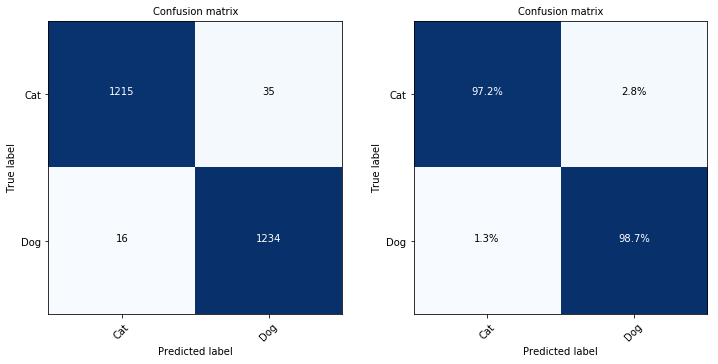

In [23]:
# Print 
 
fig = plt.figure(figsize=(12, 6))
cnf_matrix = confusion_matrix(y_test, pred, labels=[0, 1])
class_names = ['Cat', 'Dog']
np.set_printoptions(precision=1)
ax = plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix', normalize=False)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)

ax = plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix', normalize=True)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)
    
fig.subplots_adjust(bottom=0.2)

#plt.tight_layout()
plt.show()
#fig.savefig(os.path.join(MODEL_PATH, desc+'_validation_confusion_matrix.png'), facecolor='w', transparent=False)